In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide
from nixtla.utils import in_colab

In [ ]:
#| hide
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

## Why incorporate Date/Time Features in your Forecasts

Many time series display patterns that repeat based on the calendar like demand 
increasing on weekends, sales peaking at the end of the month, or traffic 
varying by hour of the day. Recognizing and capturing these time-based patterns 
can be a powerful way to improve forecasting accuracy.

While you can forecast a time series based solely on its historical values, 
adding additional date/time related features, such as the day of the 
week, month, quarter, or hour, can often enhance the model's performance. These 
features can be especially useful when your dataset lacks exogenous variables, 
but they can also complement external regressors when available.

In this tutorial, we'll walk through how to incorporate these date/time features 
into TimeGPT to boost the accuracy of your forecasts.

## How to incorporate Date/Time Features in your Forecasts

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/date_features.ipynb')

### Step 1: Import Packages

Import the necessary libraries and initialize the Nixtla client.

In [ ]:
import numpy as np
import pandas as pd
from nixtla import NixtlaClient

# For forecast evaluation
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, rmse

You can instantiate the `NixtlaClient` class providing your authentication API key.

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key='my_api_key_provided_by_nixtla'  
)

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

### Step 2: Load Data

In this notebook, we use hourly electricity prices as our example dataset, which consists of 5 time series, each with approximately 1700 data points. For demonstration purposes, we focus on the German electricity price series. The time series is split, with the last 240 steps (10 days) set aside as the test set.

For simplicity, we will also demonstrate this tutorial without the use of any additional exogenous variables, but you could extend this same technique for datasets that have exogenous variables.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df['ds'] = pd.to_datetime(df['ds'])
df_sub = df.query('unique_id == "DE"')[['unique_id','ds','y']]

In [ ]:
df_train = df_sub.query('ds < "2017-12-21"')
df_test = df_sub.query('ds >= "2017-12-21"')
df_train.shape, df_test.shape

((1440, 3), (240, 3))

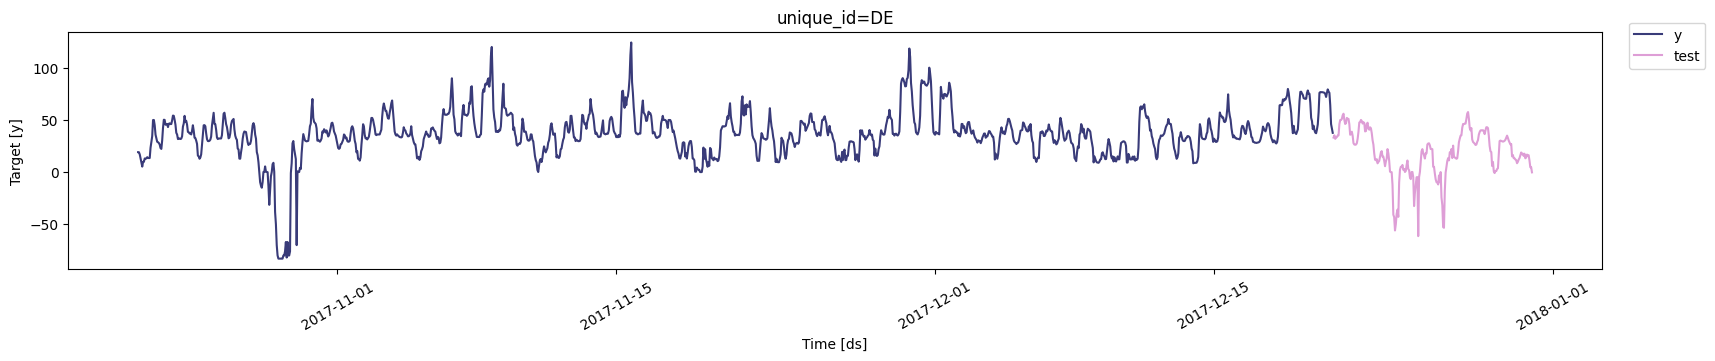

In [ ]:
nixtla_client.plot(df_train, df_test.rename(columns={'y': 'test'}))

### Step 3: Forecasting

#### Without Datetime Features

First, we forecast the univariate time series without the use of datetime features.

In [ ]:
fcst_timegpt_no_dt = nixtla_client.forecast(
    df = df_train,
    h=24*10,
    model="timegpt-1-long-horizon"
)

We will rename the forecast column so that we can distibguish it from other forecasts later.

In [ ]:
fcst_timegpt_no_dt.rename(columns={"TimeGPT": "TimeGPT_no_dt"}, inplace=True)

#### With Inbuilt Datetime Features

Next, let's forecast the same univariate time series with datetime features. This can be done by specifying the `date_features` argument. In this case, the data is hourly and we expect both the hour of the day (`hour`) and the day of the week (`dayofweek`) to impact the usage. For example, the usage may be highest in the peak afternoon and drop off at night. Also, the usage may be different between the weekdays and weekends due to working and holiday patterns. Hence, we should provide these features to the model to aid in forecasting.

> NOTE:
1. In order to show how these features are created, we can add the `feature_contribution` agrument. This is just for demonstration purposes in this tutorial and not truly needed to forecast with datetime features.
2. If you have a weekly frequency dataset, you can use `date_features = ["week", "month", "year"]` or a subset of these features.
3. If you have a monthly frequency dataset, you can use `date_features = ["month", "year"]` or a subset of these features.

In [ ]:
fcst_timegpt_dt_no_ohe = nixtla_client.forecast(
    df = df_train,
    h=24*10,
    model="timegpt-1-long-horizon",
    date_features=['hour', 'dayofweek'],
    feature_contributions=True
)

In [ ]:
shap_df = nixtla_client.feature_contributions
shap_df.head()

,unique_id,ds,TimeGPT,hour,dayofweek,base_value
0,DE,2017-12-21 00:00:00,34.945976,-12.797431,4.236599,43.506810
1,DE,2017-12-21 01:00:00,33.700954,-14.274811,4.168986,43.806778
2,DE,2017-12-21 02:00:00,32.120293,-15.785894,4.123096,43.783092
3,DE,2017-12-21 03:00:00,32.544914,-15.623017,4.542475,43.625454
4,DE,2017-12-21 04:00:00,33.698105,-14.559433,4.525819,43.731720


As we can see, two new exogenous features (`hour` and `dayofweek`) got added to the dataset and the forecast utilized these features.

However, we need to ensure that the model treats each hour (0, 1, 2, ..., 23) and each day (0, 1, 2, ..., 6) as a categorical variable and not as a numerical variable as in the case above. For example,  if these are treated as numeric variables, the impact of "hour 23" may be 23 times the impact of "hour 1" (approximating). This is not true in real life. The temperature and electricity usage in hour 23 is usually close to the usage in hour 1. Similarly, the usage on "day 6" is close to the usage on "day 0" and not 6 times the usage. Hence, we one hot encode these variables using the `date_features_to_one_hot` argument. This creates a separate exogenous feature for each hour and each day and their impacts can be captured independently.

In [ ]:
fcst_timegpt_dt = nixtla_client.forecast(
    df = df_train,
    h=24*10,
    model="timegpt-1-long-horizon",
    date_features=['hour', 'dayofweek'],
    date_features_to_one_hot=['hour', 'dayofweek'],
    feature_contributions=True
)

In [ ]:
shap_df = nixtla_client.feature_contributions
shap_df.head()

,unique_id,ds,TimeGPT,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,hour_22,hour_23,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,base_value
0,DE,2017-12-21 00:00:00,35.248108,-13.396377,0.387143,0.423001,0.392672,0.373034,0.333778,0.147671,...,0.271507,0.393282,0.472389,-0.377321,-0.548429,-0.101086,-0.133001,1.455560,2.975230,44.333805
1,DE,2017-12-21 01:00:00,34.400800,0.358443,-14.488875,0.389985,0.359990,0.341219,0.320964,0.135058,...,0.266497,0.391259,0.445456,-0.306117,-0.436959,-0.172850,-0.151865,1.533456,3.022358,44.539093
2,DE,2017-12-21 02:00:00,33.175526,0.375983,0.372809,-15.824338,0.348533,0.351379,0.317832,0.123833,...,0.273698,0.410714,0.417348,-0.279551,-0.342991,-0.171547,-0.142890,1.532721,3.042772,44.515614
3,DE,2017-12-21 03:00:00,33.205390,0.368333,0.366936,0.372584,-15.880591,0.346306,0.319877,0.136488,...,0.276705,0.416273,0.508190,-0.274014,-0.339005,-0.176228,-0.152890,1.588364,3.095226,44.391410
4,DE,2017-12-21 04:00:00,34.689583,0.363581,0.363459,0.393807,0.362043,-14.755774,0.314718,0.141911,...,0.274819,0.402653,0.531417,-0.277548,-0.360688,-0.159342,-0.169762,1.692538,3.165733,44.505848


As we can see above, this now creates a separate feature for each hour of the day and each day of the week.

> NOTE: With one hot encoding, the number of features can increase by a lot. This is especially true if you have weekly frequency data and you are using  `date_feature=["week"]` because this leads to 52 features being created after one hot encoding. Please make sure that your dataset has enough datapoints or else the model will overfit to the data. You can increase the number of datapoints in the dataset by increasing the available history for your time series, or increasing the number of unique time series that share a common pattern in your dataset.

In [ ]:
fcst_timegpt_dt.rename(columns={"TimeGPT": "fcst_timegpt_dt"}, inplace=True)

#### With Custom Datetime Features

In the example above, we saw how to incorporate the inbuilt datetime features into the forecast. However, as seen above, in some cases, it may not be feasible to one hot encode the datetime features since it may lead to a large number of features for the dataset size. In that case, we can create a custom datetime feature and use it in the forecast.

In this example, we will create a sine/cosine encoder for the week which is a popular technique to encode datetime features due to their circular nature described above (e.g. hour 23 behavior is close to hour 0 behavior, week 52 behavior is very close to week 1 behavior, etc.).

In [ ]:
class SinCosWeekOfYear:
    """
    Adds sine and cosine features for each week of the year. This is useful for
    models that can benefit from understanding the periodicity of weeks in a year.
    """
    def __call__(self, dates: pd.DatetimeIndex):
        df = pd.DataFrame(index=dates)
        # Get week of year (1 to 53)
        weeks = np.array([date.isocalendar().week for date in dates])

        # Calculate sine and cosine features
        df["week_sin"] = np.sin((2 * np.pi) * (weeks-1) / 53).round(4)
        df["week_cos"] = np.cos((2 * np.pi) * (weeks-1) / 53).round(4)
        return df

    def __name__(self):
        return "SinCosWeekOfYear"

# Example usage
dates = pd.date_range(start='2023-01-01', periods=55, freq='W-MON')
sin_cos_week = SinCosWeekOfYear()
features = sin_cos_week(dates)
features.tail()

,week_sin,week_cos
2023-12-18,-0.3482,0.9374
2023-12-25,-0.2349,0.9720
2024-01-01,0.0000,1.0000
2024-01-08,0.1183,0.9930
2024-01-15,0.2349,0.9720


As we can see above, because of the cyclical encoding of the datetime feature, the encoded values (`week_sin` and `week_cos`) for week 2023-12-25 (week 52) is very close to 2024-01-01 (week 1). This will ensure that the learned features for week 52 will be close to those for week 1. This has also helped us get the feature cardinality down from 53 (in case of one hot encoding) to only 2 features.

In our example, we have the hour feature wich has a relatively high cardinality after one hot encoding. Let's encode this with sine and cosine features and use this instead of the one hot encoding.

In [ ]:
class SinCosHourOfDay:
    """
    Adds sine and cosine features for each hour of the day. This is useful for
    models that can benefit from understanding the periodicity of hours in a day.
    """
    def __call__(self, dates: pd.DatetimeIndex):
        df = pd.DataFrame(index=dates)
        # Get hour of day (0 to 23)
        hours = np.array([date.hour for date in dates])

        # Calculate sine and cosine features
        df["hour_sin"] = np.sin((2 * np.pi) * (hours) / 24).round(4)
        df["hour_cos"] = np.cos((2 * np.pi) * (hours) / 24).round(4)
        return df

    def __name__(self):
        return "SinCosHourOfDay"

# Example usage
dates = pd.date_range(start='2023-01-01 00:00', periods=26, freq='h')
sin_cos_hour = SinCosHourOfDay()
features = sin_cos_hour(dates)
features.tail()

,hour_sin,hour_cos
2023-01-01 21:00:00,-0.7071,0.7071
2023-01-01 22:00:00,-0.5000,0.8660
2023-01-01 23:00:00,-0.2588,0.9659
2023-01-02 00:00:00,0.0000,1.0000
2023-01-02 01:00:00,0.2588,0.9659


In order to use this custom datetime feature, we can simply pass an instance of the class to the `date_features` argument. Since this is alreay encoded, we do not need to include it in the `date_features_to_one_hot` argument.

In [ ]:
fcst_timegpt_dt_custom = nixtla_client.forecast(
    df = df_train,
    h=24*10,
    model="timegpt-1-long-horizon",
    date_features=[SinCosHourOfDay(), 'dayofweek'],
    date_features_to_one_hot=['dayofweek'],
    feature_contributions=True
)

In [ ]:
shap_df = nixtla_client.feature_contributions
shap_df.head()

,unique_id,ds,TimeGPT,hour_sin,hour_cos,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,base_value
0,DE,2017-12-21 00:00:00,35.801600,-3.609636,-9.003666,0.805974,-0.424078,-0.343238,-0.428668,-0.055370,1.462214,3.295479,44.102590
1,DE,2017-12-21 01:00:00,34.419390,-3.824628,-10.493365,0.714771,-0.400898,-0.282606,-0.331269,-0.115753,1.539153,3.245723,44.368263
2,DE,2017-12-21 02:00:00,32.892105,-4.959243,-10.772224,0.712402,-0.439891,-0.261654,-0.207954,-0.191223,1.481960,3.206257,44.323673
3,DE,2017-12-21 03:00:00,32.727295,-5.161374,-10.812295,0.771099,-0.417504,-0.262543,-0.146066,-0.258350,1.578070,3.268950,44.167310
4,DE,2017-12-21 04:00:00,34.121994,-3.687167,-11.353230,0.846524,-0.387008,-0.278475,-0.169525,-0.255498,1.788180,3.362950,44.255240


As we can see above, the hour has now gotten encoded using the sine and cosine features instead of the one hot encoding.

In [ ]:
fcst_timegpt_dt_custom.rename(columns={"TimeGPT": "fcst_timegpt_dt_custom"}, inplace=True)

### Step 4: Compare Results

#### Visual Comparison

Let's compare the results visually first. For this, we will merge all the forecasts together. This is why we had renamed the forecast columns above so that we can distinguish the forecasts generated by the different methods.

In [ ]:
all_fcst = (
    fcst_timegpt_no_dt
    .merge(
        fcst_timegpt_dt,
        on=['unique_id', 'ds'],
    )
    .merge(
        fcst_timegpt_dt_custom,
        on=['unique_id', 'ds'],
    )
)
all_fcst.head()

,unique_id,ds,TimeGPT_no_dt,fcst_timegpt_dt,fcst_timegpt_dt_custom
0,DE,2017-12-21 00:00:00,34.340740,35.248108,35.801600
1,DE,2017-12-21 01:00:00,34.376488,34.400800,34.419390
2,DE,2017-12-21 02:00:00,32.215570,33.175526,32.892105
3,DE,2017-12-21 03:00:00,34.485695,33.205390,32.727295
4,DE,2017-12-21 04:00:00,34.359673,34.689583,34.121994


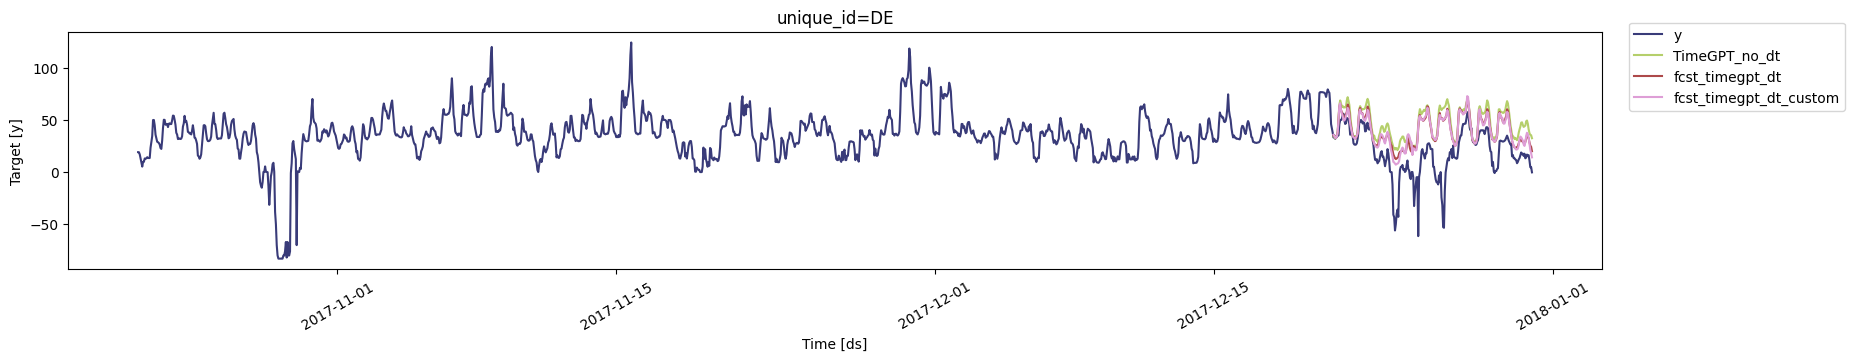

In [ ]:
nixtla_client.plot(df_sub, all_fcst)

Visually looking at the results shows that the forecast with the datetime features is closer to the actuals as compared to the forecast without the datetime features.

#### Metric Comparison

Next, let's compare the forecast with the actual data quantitatively. We will use two common metrics - `MAE` and `RMSE` for this purpose.

In [ ]:
all_fcst_with_actuals = (
    df_test[["unique_id", "ds", "y"]]
    .merge(all_fcst, on=['unique_id', 'ds'])
)
all_fcst_with_actuals.head()

,unique_id,ds,y,TimeGPT_no_dt,fcst_timegpt_dt,fcst_timegpt_dt_custom
0,DE,2017-12-21 00:00:00,33.09,34.340740,35.248108,35.801600
1,DE,2017-12-21 01:00:00,35.26,34.376488,34.400800,34.419390
2,DE,2017-12-21 02:00:00,31.88,32.215570,33.175526,32.892105
3,DE,2017-12-21 03:00:00,33.04,34.485695,33.205390,32.727295
4,DE,2017-12-21 04:00:00,33.60,34.359673,34.689583,34.121994


In [ ]:
metrics = [mae, rmse]

evaluation = evaluate(
    all_fcst_with_actuals,
    metrics=metrics,
)
evaluation

,unique_id,metric,TimeGPT_no_dt,fcst_timegpt_dt,fcst_timegpt_dt_custom
0,DE,mae,27.527012,21.644545,21.139603
1,DE,rmse,33.478168,28.099654,27.616988


As we can see, the addition of the datetime features improved the forecasting 
metrics compared to the baseline model created without these features.

## Conclusion

As demonstrated in this tutorial

1. Providing datetime features to the model during forecasting can improve the metrics substantially.
2. However, users must be careful of the cardinality of the features after datetime features have been added. If the feature cardinality is too large for the dataset, it may lead to overfitting.
3. In case of high cardinality, users may consider a custom encoding approach as demonstrated.